# Сегментация клиентов по 3 категориям

 **Обучение с учителем**  
 **Мультиклассовая классификация** 

Задача разделить клиентов на три класса в тестовой выборке.  
Метрика оценки классификатора: `macro_f_score`  
Ожидаемое значение метрики: >=`0.5`  

**Описание данных:**  
 *contest_train.csv*  
`ID` - id клиентов  
`FEATURE_0…259` - данные клиента  
`TARGET` - целевой признак (класс клиента)  

 *contest_test.csv*  
 `ID` - id клиентов  
`FEATURE_0…259` - данные клиента   





## Загрузка и анализ данных

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)
from pandas_profiling import ProfileReport as pr

!pip install optuna
import optuna
import numpy as np
import seaborn as sns
from datetime import datetime
from xgboost import XGBClassifier
import matplotlib.pyplot as plt  
from scipy.stats import yeojohnson
from lightgbm import LGBMClassifier
!pip install catboost
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.simplefilter(action='ignore')

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:

test = pd.read_csv('../input/gfhfghfgh/contest_test.csv')
train = pd.read_csv('../input/gfhfghfgh/contest_train.csv')


In [3]:
train.sample(10, random_state=42)

,ID,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,FEATURE_12,FEATURE_13,FEATURE_14,FEATURE_15,FEATURE_16,FEATURE_17,FEATURE_18,FEATURE_19,FEATURE_20,FEATURE_21,FEATURE_22,FEATURE_23,FEATURE_24,FEATURE_25,FEATURE_26,FEATURE_27,FEATURE_28,FEATURE_29,FEATURE_30,FEATURE_31,FEATURE_32,FEATURE_33,FEATURE_34,FEATURE_35,FEATURE_36,FEATURE_37,FEATURE_38,FEATURE_39,FEATURE_40,FEATURE_41,FEATURE_42,FEATURE_43,FEATURE_44,FEATURE_45,FEATURE_46,FEATURE_47,FEATURE_48,FEATURE_49,FEATURE_50,FEATURE_51,FEATURE_52,FEATURE_53,FEATURE_54,FEATURE_55,FEATURE_56,FEATURE_57,FEATURE_58,FEATURE_59,FEATURE_60,FEATURE_61,FEATURE_62,FEATURE_63,FEATURE_64,FEATURE_65,FEATURE_66,FEATURE_67,FEATURE_68,FEATURE_69,FEATURE_70,FEATURE_71,FEATURE_72,FEATURE_73,FEATURE_74,FEATURE_75,FEATURE_76,FEATURE_77,FEATURE_78,FEATURE_79,FEATURE_80,FEATURE_81,FEATURE_82,FEATURE_83,FEATURE_84,FEATURE_85,FEATURE_86,FEATURE_87,FEATURE_88,FEATURE_89,FEATURE_90,FEATURE_91,FEATURE_92,FEATURE_93,FEATURE_94,FEATURE_95,FEATURE_96,FEATURE_97,FEATURE_98,FEATURE_99,FEATURE_100,FEATURE_101,FEATURE_102,FEATURE_103,FEATURE_104,FEATURE_105,FEATURE_106,FEATURE_107,FEATURE_108,FEATURE_109,FEATURE_110,FEATURE_111,FEATURE_112,FEATURE_113,FEATURE_114,FEATURE_115,FEATURE_116,FEATURE_117,FEATURE_118,FEATURE_119,FEATURE_120,FEATURE_121,FEATURE_122,FEATURE_123,FEATURE_124,FEATURE_125,FEATURE_126,FEATURE_127,FEATURE_128,FEATURE_129,FEATURE_130,FEATURE_131,FEATURE_132,FEATURE_133,FEATURE_134,FEATURE_135,FEATURE_136,FEATURE_137,FEATURE_138,FEATURE_139,FEATURE_140,FEATURE_141,FEATURE_142,FEATURE_143,FEATURE_144,FEATURE_145,FEATURE_146,FEATURE_147,FEATURE_148,FEATURE_149,FEATURE_150,FEATURE_151,FEATURE_152,FEATURE_153,FEATURE_154,FEATURE_155,FEATURE_156,FEATURE_157,FEATURE_158,FEATURE_159,FEATURE_160,FEATURE_161,FEATURE_162,FEATURE_163,FEATURE_164,FEATURE_165,FEATURE_166,FEATURE_167,FEATURE_168,FEATURE_169,FEATURE_170,FEATURE_171,FEATURE_172,FEATURE_173,FEATURE_174,FEATURE_175,FEATURE_176,FEATURE_177,FEATURE_178,FEATURE_179,FEATURE_180,FEATURE_181,FEATURE_182,FEATURE_183,FEATURE_184,FEATURE_185,FEATURE_186,FEATURE_187,FEATURE_188,FEATURE_189,FEATURE_190,FEATURE_191,FEATURE_192,FEATURE_193,FEATURE_194,FEATURE_195,FEATURE_196,FEATURE_197,FEATURE_198,FEATURE_199,FEATURE_200,FEATURE_201,FEATURE_202,FEATURE_203,FEATURE_204,FEATURE_205,FEATURE_206,FEATURE_207,FEATURE_208,FEATURE_209,FEATURE_210,FEATURE_211,FEATURE_212,FEATURE_213,FEATURE_214,FEATURE_215,FEATURE_216,FEATURE_217,FEATURE_218,FEATURE_219,FEATURE_220,FEATURE_221,FEATURE_222,FEATURE_223,FEATURE_224,FEATURE_225,FEATURE_226,FEATURE_227,FEATURE_228,FEATURE_229,FEATURE_230,FEATURE_231,FEATURE_232,FEATURE_233,FEATURE_234,FEATURE_235,FEATURE_236,FEATURE_237,FEATURE_238,FEATURE_239,FEATURE_240,FEATURE_241,FEATURE_242,FEATURE_243,FEATURE_244,FEATURE_245,FEATURE_246,FEATURE_247,FEATURE_248,FEATURE_249,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259,TARGET
17886,446164636,4.0,2.0,0.0,0.0,0.0,0.0,0.0,-49.451051,7.879458,0.0,0.0,0.0,44.868599,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,17.600857,0.0,80.154296,29.919608,0.0,-3.796891,0.0,0.0,0.0,0.0,0.0,0.0,63.380876,-49.913099,83.185763,52.385019,58.784292,85.415117,0.0,0.0,0.0,0.0,0.0,0.0,41.309317,112.571114,-87.917770,36.558392,-73.415701,43.008061,-22.925595,-17.046804,-60.798747,208.779112,95.963771,141.753006,71.797251,39.218813,18.948570,-62.290311,27.197945,53.388727,639.072686,387.202891,221.494143,387.359316,295.216882,305.125609,25.0,11.0,85.099688,5.818933,9.193404,2.0,0.0,0.225806,87.904633,-6.921472,118.279006,18.094588,41.109282,84.362896,57.212094,291.952764,0.268951,0.814214,3.125945,48.125773,0.590690,-21.202421,-59.708099,-6.525057,34.994719,-7.646795,0.037268,0.622359,22.107163,26.596965,0.247225,-0.029181,0.720059,53.024558,76.996486,1.174607,0.524295,0.699783,14.115372,33.178361,1.257154,0.333333,0.333333,8.432591,14.711068,1.000000,2.0,4.0,0.0,0.0,0.0,0.0,6.

В `train` все данные числовые (можно обойтись без кодирования строк в числа).  
Сами числа имеют разный масштаб (единицы-тысячи), нужно масштабирование признаков.  
Есть как положительные, так и отрицательные значения.  
Присутствуют пропуски.  

In [4]:
test.sample(10, random_state=12345)

,ID,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,FEATURE_12,FEATURE_13,FEATURE_14,FEATURE_15,FEATURE_16,FEATURE_17,FEATURE_18,FEATURE_19,FEATURE_20,FEATURE_21,FEATURE_22,FEATURE_23,FEATURE_24,FEATURE_25,FEATURE_26,FEATURE_27,FEATURE_28,FEATURE_29,FEATURE_30,FEATURE_31,FEATURE_32,FEATURE_33,FEATURE_34,FEATURE_35,FEATURE_36,FEATURE_37,FEATURE_38,FEATURE_39,FEATURE_40,FEATURE_41,FEATURE_42,FEATURE_43,FEATURE_44,FEATURE_45,FEATURE_46,FEATURE_47,FEATURE_48,FEATURE_49,FEATURE_50,FEATURE_51,FEATURE_52,FEATURE_53,FEATURE_54,FEATURE_55,FEATURE_56,FEATURE_57,FEATURE_58,FEATURE_59,FEATURE_60,FEATURE_61,FEATURE_62,FEATURE_63,FEATURE_64,FEATURE_65,FEATURE_66,FEATURE_67,FEATURE_68,FEATURE_69,FEATURE_70,FEATURE_71,FEATURE_72,FEATURE_73,FEATURE_74,FEATURE_75,FEATURE_76,FEATURE_77,FEATURE_78,FEATURE_79,FEATURE_80,FEATURE_81,FEATURE_82,FEATURE_83,FEATURE_84,FEATURE_85,FEATURE_86,FEATURE_87,FEATURE_88,FEATURE_89,FEATURE_90,FEATURE_91,FEATURE_92,FEATURE_93,FEATURE_94,FEATURE_95,FEATURE_96,FEATURE_97,FEATURE_98,FEATURE_99,FEATURE_100,FEATURE_101,FEATURE_102,FEATURE_103,FEATURE_104,FEATURE_105,FEATURE_106,FEATURE_107,FEATURE_108,FEATURE_109,FEATURE_110,FEATURE_111,FEATURE_112,FEATURE_113,FEATURE_114,FEATURE_115,FEATURE_116,FEATURE_117,FEATURE_118,FEATURE_119,FEATURE_120,FEATURE_121,FEATURE_122,FEATURE_123,FEATURE_124,FEATURE_125,FEATURE_126,FEATURE_127,FEATURE_128,FEATURE_129,FEATURE_130,FEATURE_131,FEATURE_132,FEATURE_133,FEATURE_134,FEATURE_135,FEATURE_136,FEATURE_137,FEATURE_138,FEATURE_139,FEATURE_140,FEATURE_141,FEATURE_142,FEATURE_143,FEATURE_144,FEATURE_145,FEATURE_146,FEATURE_147,FEATURE_148,FEATURE_149,FEATURE_150,FEATURE_151,FEATURE_152,FEATURE_153,FEATURE_154,FEATURE_155,FEATURE_156,FEATURE_157,FEATURE_158,FEATURE_159,FEATURE_160,FEATURE_161,FEATURE_162,FEATURE_163,FEATURE_164,FEATURE_165,FEATURE_166,FEATURE_167,FEATURE_168,FEATURE_169,FEATURE_170,FEATURE_171,FEATURE_172,FEATURE_173,FEATURE_174,FEATURE_175,FEATURE_176,FEATURE_177,FEATURE_178,FEATURE_179,FEATURE_180,FEATURE_181,FEATURE_182,FEATURE_183,FEATURE_184,FEATURE_185,FEATURE_186,FEATURE_187,FEATURE_188,FEATURE_189,FEATURE_190,FEATURE_191,FEATURE_192,FEATURE_193,FEATURE_194,FEATURE_195,FEATURE_196,FEATURE_197,FEATURE_198,FEATURE_199,FEATURE_200,FEATURE_201,FEATURE_202,FEATURE_203,FEATURE_204,FEATURE_205,FEATURE_206,FEATURE_207,FEATURE_208,FEATURE_209,FEATURE_210,FEATURE_211,FEATURE_212,FEATURE_213,FEATURE_214,FEATURE_215,FEATURE_216,FEATURE_217,FEATURE_218,FEATURE_219,FEATURE_220,FEATURE_221,FEATURE_222,FEATURE_223,FEATURE_224,FEATURE_225,FEATURE_226,FEATURE_227,FEATURE_228,FEATURE_229,FEATURE_230,FEATURE_231,FEATURE_232,FEATURE_233,FEATURE_234,FEATURE_235,FEATURE_236,FEATURE_237,FEATURE_238,FEATURE_239,FEATURE_240,FEATURE_241,FEATURE_242,FEATURE_243,FEATURE_244,FEATURE_245,FEATURE_246,FEATURE_247,FEATURE_248,FEATURE_249,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259
4708,1388120591,11.0,3.0,0.0,0.0,0.0,0.0,0.0,-13.583718,-18.228351,0.0,0.0,0.0,27.140446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.908504,0.0,-0.865549,-0.582946,0.0,-30.729893,0.0,0.0,0.0,0.0,0.0,0.0,67.801687,-136.381174,32.309789,-54.905459,-15.150239,-31.496623,0.0,0.0,0.0,0.0,0.0,0.0,-8.517135,-24.160292,-7.788143,6.176868,-2.850066,-13.547183,35.104514,-89.617656,-71.820870,20.720479,10.890128,81.937533,385.470309,315.692369,773.101806,525.464123,403.259412,342.392697,430.418977,265.897934,814.746355,471.635376,532.842388,334.324469,19.0,0.0,313.529262,272.886922,303.025377,15.0,0.0,2.677419,-1.722149,1.282381,-7.506406,11.171896,33.486614,57.878214,170.131012,258.177622,-0.098230,0.387538,-0.537517,2.155602,0.098993,-34.880149,22.170912,3.141336,15.838822,1.682137,-0.044495,7.804742,3.110202,33.638513,4.797653,0.449130,21.298652,6.697455,103.851710,13.901537,0.535287,3.830027,4.815101,38.844887,3.114939,0.000000,1.166667,1.895687,8.511228,1.000000,2.0,2.0,1.0,2.0,1.0,2.0,7

Та же картина наблюдается и в `test`.

In [5]:

print('Train info:\n')
print(train.info(memory_usage='deep'))
print('\n', '-'*40, '\n')
print('Test info:\n')
print(test.info(memory_usage='deep'))


Train info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18390 entries, 0 to 18389
Columns: 262 entries, ID to TARGET
dtypes: float64(260), int64(2)
memory usage: 36.8 MB
None

 ---------------------------------------- 

Test info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6131 entries, 0 to 6130
Columns: 261 entries, ID to FEATURE_259
dtypes: float64(260), int64(1)
memory usage: 12.2 MB
None


Расход памяти небольшой, оптимизация на данном этапе не требуется.  
Тип данных везде числовой, в преобразовании не нуждается.  

Признаков более двух сотен.  
Точного их значения мы не знаем.  
Метод `describe()` будет неудобен в данном случае.  
Мы воспользуемся `Pandas Profiling Report` для удобства восприятия данных.  

In [6]:
pr(train, minimal=True).to_widgets()

Summarize dataset:   0%|          | 0/270 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

На вкладке `Warnings` мы видим возможные проблемы в данных.  
Начнем проверку сверху вниз.  

Первые строки отчета говорят о преобладании одного значения над другими, признак становится почти константным.  
Но, посмотрев более детальный отчет, стало ясно, что значений там несколько.  
(возможно нулями ранее заполнили пропуски, но нам это не известно)  
Это может быть информацией, поэтому не будем их менять.   

Далее идут колонки с пропусками, удалим колонки где пропусков почти половина.  
(заполнять их другими значениями будет не верно в таком масштабе)  

Затем идут принаки имеющие ассиметричное (скошенное распределение), поправим это трансформацией `Yeo-Johnson`  

Следующие колонки содержат только уникальные значения, как будто это своеобразные `ID`  
От них нужно избавится, они не принесут полезной информации в модель, раз значение признака не повторяется.  

В конце мы видим предупреждение о сильной разреженности данных, либо о колонках содержащих одни нули.  
Датасет не слишком большой, разреженные данные пока оставим, возможно в них есть нужная информация.  
Удалим колонки с одними нулями и прочими константными значениями.  

По количеству нулей в `TARGET` виден дисбаланс классов.  
Так как наша выборка не велика, воспользуемся `SMOTE`  
(увеличим количество недостающих признаков синтезированием похожих, а не просто копированием)

Опишем столбцы с большим количеством пропусков.

In [7]:

col_with_miss_val = [
    'FEATURE_187',
    'FEATURE_189',
    'FEATURE_190',
    'FEATURE_191',
    'FEATURE_192',
    'FEATURE_193',
    'FEATURE_194'
]


Найдем столбцы с полностью уникальными значениями.

In [8]:

def all_unique_col(df):
    return [
        col for col in list(df) if len(df[col].unique()) == len(df)
    ]


In [9]:

all_unique_col = all_unique_col(train)
all_unique_col.remove('ID')


Теперь найдем столбцы с одним единственным значением.

In [10]:

def non_unique_col(df):
    return [
        col for col in list(df) if len(df[col].unique()) == 1
    ]


In [11]:
non_unique_col = non_unique_col(train)

Удалим отобранные столбцы.

In [12]:

def drop_columns(df, columns):
    return df.drop(columns, axis=1, inplace=True)


In [13]:

col_to_del = col_with_miss_val + all_unique_col + non_unique_col

for df in [train, test]:
        df = drop_columns(df, col_to_del)
        

У нас еще остались пропуски, проверим какой процент строк мы потеряем если их удалим.  

In [14]:

train_copy = train.copy()
print(
    'Доля строк с пропусками составляет: ',
    round(
        1 - len(train_copy.dropna()) / len(train),
        3
    )
)


Доля строк с пропусками составляет:  0.311


Их почти треть, лучше их заполнить.  
Воспользуемся для этого `KNNImputer`

In [15]:

def impute_nans_with_knn(df, columns, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    return pd.DataFrame(
        imputer.fit_transform(df),
        columns=columns
    )

In [16]:

columns = train.iloc[:, 1:-1].columns

for df in [train, test]:
        df[columns] = impute_nans_with_knn(df[columns], columns)


In [17]:

display(
    train.isnull().sum().sum(),
    test.isnull().sum().sum()
)


0

0

Проверим дубликаты.  

In [18]:

display(
    train.duplicated().sum(),
    test.duplicated().sum()
)


0

0

Посмотрим на корреляцию.  
Мы не можем оценить зависимость одних признаков от других на первый взгляд, так как не знаем их сути.  
Но можем вычислить парные корреляции.  
Нас интересуют высокие абсолютные значения.  

In [19]:

def get_high_corr_col(df, corr_coeff=0.8):
    corr_matrix = df.corr().abs()
    high_corr_col = np.where(corr_matrix>corr_coeff)
    return [
        (
            corr_matrix.columns[x],
            corr_matrix.columns[y]
        ) for x, y in zip(*high_corr_col) if x != y and x < y
    ]


In [20]:
high_corr_col = get_high_corr_col(train)
high_corr_col

[('FEATURE_4', 'FEATURE_10'),
 ('FEATURE_9', 'FEATURE_10'),
 ('FEATURE_43', 'FEATURE_231'),
 ('FEATURE_70', 'FEATURE_214'),
 ('FEATURE_71', 'FEATURE_72'),
 ('FEATURE_71', 'FEATURE_73'),
 ('FEATURE_71', 'FEATURE_195'),
 ('FEATURE_72', 'FEATURE_73'),
 ('FEATURE_72', 'FEATURE_195'),
 ('FEATURE_73', 'FEATURE_195'),
 ('FEATURE_74', 'FEATURE_76'),
 ('FEATURE_115', 'FEATURE_116'),
 ('FEATURE_117', 'FEATURE_118'),
 ('FEATURE_117', 'FEATURE_119'),
 ('FEATURE_117', 'FEATURE_120'),
 ('FEATURE_118', 'FEATURE_119'),
 ('FEATURE_118', 'FEATURE_120'),
 ('FEATURE_119', 'FEATURE_120'),
 ('FEATURE_124', 'FEATURE_125'),
 ('FEATURE_124', 'FEATURE_126'),
 ('FEATURE_128', 'FEATURE_129'),
 ('FEATURE_128', 'FEATURE_130'),
 ('FEATURE_132', 'FEATURE_133'),
 ('FEATURE_132', 'FEATURE_134'),
 ('FEATURE_136', 'FEATURE_138'),
 ('FEATURE_149', 'FEATURE_150'),
 ('FEATURE_149', 'FEATURE_153'),
 ('FEATURE_150', 'FEATURE_153'),
 ('FEATURE_154', 'FEATURE_158'),
 ('FEATURE_155', 'FEATURE_158'),
 ('FEATURE_165', 'FEATURE_166

Видим что есть столбцы с высокой парной (и не только) корреляцией.  
В таком случае можно построить новые признаки (но мы не знаем их смысла), не трогать, удалить, или увеличить выборку.  
Выборку мы увеличим на следующем шаге, а сейчас удалим признаки с высокой парной корреляцией.  
`TARGET` не попал в наш список.

In [21]:

high_corr_col = [col[0] for col in high_corr_col]
high_corr_col_without_dupl = set(high_corr_col)

for df in [train, test]:
        df = drop_columns(
            df,
            high_corr_col_without_dupl
        )


In [22]:

display(
    get_high_corr_col(train),
    get_high_corr_col(test)
)


[]

[]

Отлично, больше нет столбцов с высокой корреляцией.  

In [23]:
print(
    'train.shape:',
    train.shape,
    '\n',
    'test.shape:',
    test.shape
)

train.shape: (18390, 115) 
 test.shape: (6131, 114)


Поработаем с балансом классов.  

In [24]:
X_train = train.iloc[:, 1:-1].copy()
y_train = train['TARGET'].copy()

In [25]:

sm = SMOTE(random_state=42, k_neighbors=5)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train) 


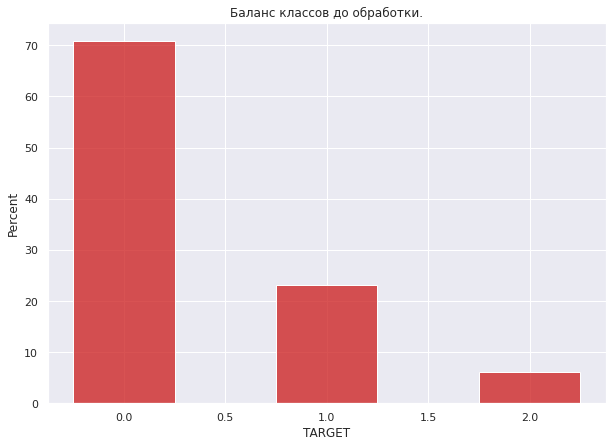

In [26]:

sns.set(rc={'figure.figsize': (10, 7)})

sns.histplot(
    y_train,
    stat='percent',
    discrete=True,
    color=[0.8, 0.1, 0.1],
    shrink=.5
).set_title('Баланс классов до обработки.');


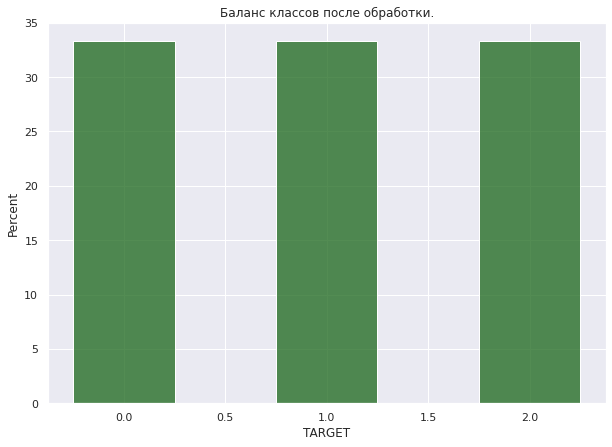

In [27]:

sns.histplot(
    y_train_res,
    stat='percent',
    discrete=True,
    color=[0.1, 0.4, 0.1],
    shrink=.5
).set_title('Баланс классов после обработки.');


Перемешаем данные случайным образом.

In [28]:
features, target = shuffle(X_train_res, y_train_res, random_state=12345)

Последнее что мы сделаем, перед тренировкой моделей, это обучим `StandardScaler` и масштабируем признаки.  
Сразу подготовим `features_scaled` для обучения модели после подбора параметров.  

In [29]:

scaler = StandardScaler()
scaler.fit(features)

features_scaled = features.copy()

features_scaled = pd.DataFrame(
    scaler.transform(features_scaled),
    columns=features.columns
)

X_test = pd.DataFrame(
    scaler.transform(test.iloc[:, 1:]),
    columns=features.columns
)


In [30]:
X_test.head()

,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_5,FEATURE_6,FEATURE_8,FEATURE_10,FEATURE_11,FEATURE_12,FEATURE_13,FEATURE_14,FEATURE_15,FEATURE_16,FEATURE_17,FEATURE_18,FEATURE_19,FEATURE_20,FEATURE_22,FEATURE_25,FEATURE_27,FEATURE_28,FEATURE_29,FEATURE_30,FEATURE_31,FEATURE_32,FEATURE_39,FEATURE_40,FEATURE_41,FEATURE_42,FEATURE_44,FEATURE_69,FEATURE_75,FEATURE_76,FEATURE_110,FEATURE_111,FEATURE_114,FEATURE_116,FEATURE_120,FEATURE_121,FEATURE_122,FEATURE_123,FEATURE_125,FEATURE_126,FEATURE_127,FEATURE_129,FEATURE_130,FEATURE_131,FEATURE_133,FEATURE_134,FEATURE_135,FEATURE_137,FEATURE_138,FEATURE_139,FEATURE_140,FEATURE_141,FEATURE_142,FEATURE_145,FEATURE_146,FEATURE_148,FEATURE_151,FEATURE_152,FEATURE_153,FEATURE_156,FEATURE_157,FEATURE_158,FEATURE_159,FEATURE_162,FEATURE_167,FEATURE_173,FEATURE_174,FEATURE_175,FEATURE_176,FEATURE_178,FEATURE_179,FEATURE_180,FEATURE_181,FEATURE_185,FEATURE_188,FEATURE_195,FEATURE_196,FEATURE_197,FEATURE_198,FEATURE_199,FEATURE_201,FEATURE_202,FEATURE_207,FEATURE_214,FEATURE_216,FEATURE_218,FEATURE_219,FEATURE_220,FEATURE_222,FEATURE_224,FEATURE_226,FEATURE_227,FEATURE_229,FEATURE_231,FEATURE_234,FEATURE_238,FEATURE_239,FEATURE_242,FEATURE_243,FEATURE_245,FEATURE_246,FEATURE_247,FEATURE_248,FEATURE_250,FEATURE_251,FEATURE_254,FEATURE_255,FEATURE_257,FEATURE_258,FEATURE_259
0,-0.367973,-0.746686,-0.221697,-0.012832,-0.118920,-0.139912,-0.429604,2.266181,-0.170472,-0.241189,-0.509646,3.050894,-0.376050,3.078785,-0.356951,-0.371794,-0.000666,0.010268,-0.050704,-0.020155,-0.015353,-0.028432,-0.025347,-0.016885,-0.009572,-0.097371,-0.094069,-0.076144,-0.068849,-0.062181,0.462391,-0.066008,-0.308217,-0.389558,-0.199758,1.884181,0.648849,-0.273437,-0.132086,0.850353,0.984121,1.074924,0.023545,-1.303970,1.010033,0.161390,0.826258,-0.505811,-0.484618,0.799824,-0.387981,-0.179970,-0.043478,-0.069249,-0.046272,-0.098276,-0.104838,-0.050253,-0.181852,-0.270605,-0.201448,-0.105717,-0.121737,-0.159716,-0.203305,-0.008729,0.110945,-0.755680,0.237949,-0.316997,0.361297,-0.192629,-0.482925,-0.287775,0.614743,-0.631754,-0.502458,-0.279987,-0.519833,-0.407831,-0.174894,-0.127994,0.725467,-0.192934,-0.179033,1.430792,0.560856,-0.057460,-0.605216,-0.688640,-0.637044,0.172292,-0.075658,0.041166,0.554930,-0.025314,-0.082287,-0.108673,-0.280831,0.518046,-0.159068,-0.264122,-0.193884,-0.110606,-0.155001,0.417965,-0.387201,-0.323640,-1.647117,0.754805,-0.423111,-0.533334,-0.510879
1,-0.367973,-0.746686,-0.221697,-0.012832,-0.118920,-0.225067,-0.429604,-0.488896,-0.663134,-0.312688,-0.984848,-0.380847,-0.376050,-0.374375,-0.356951,-0.371794,-0.000666,0.010268,-0.050704,-0.020155,-0.015353,-0.028432,-0.025347,-0.016885,-0.009572,-0.097371,-0.094069,-0.076144,-0.068849,-0.062181,0.590856,-0.066008,-0.319055,-0.219118,-0.523396,-0.337304,-0.068295,-0.273437,-0.070343,-0.218228,0.984121,-0.551163,-0.299794,0.908114,-0.497199,-0.042735,0.826258,-0.102841,-0.418073,-0.574181,-0.211763,-0.344745,-0.043478,-0.069249,-0.046272,-0.309133,-0.104838,-0.050253,-1.044836,-0.270605,-0.201448,-0.049085,-0.121737,-0.159716,-0.043758,-0.008729,-0.793173,-0.454470,-0.393032,-0.457470,1.009412,-0.192629,-0.482925,-0.287775,0.293856,0.753944,-0.502458,0.306406,-0.424058,-0.420059,-0.174894,-0.302807,-0.377720,-0.192934,-0.179033,1.430792,-0.711370,-0.421631,1.164955,-0.688640,-0.637044,-0.343754,-0.131441,0.064631,0.212732,-0.025314,-0.082287,-0.108673,-0.517184,-0.442982,-0.159068,-0.264122,-0.193884,-0.110606,-0.155001,0.452877,-0.387201,-0.323640,0.709904,0.754805,-0.423111,-0.533334,-0.510879
2,0.998342,1.807355,-0.221697,-0.012832,10.089845,0.798119,1.671425,2.266181,-0.560275,-0.169689,-0.509646,-0.380847,-0.376050,3.078785,-0.356951,3.129006,-0.000666,0.010268,-0.050704,-0.020155,-0.015353,-0.028432,-0.025347,-0.016885,-0.009572,-0.097371,-0.094069,-0.076144,-0.068849,-0.062181,0.719320,-0.066008,-0.329893,-0.389558,-0.037939,0.822805,0.388069,7.447213,1.349763,1.651789,-1.252922,-0.280149,-0.299794,-0.821015,0.077904,-0.361316,0.826258,-0.395

Теперь приблизим распределение признаков к нормальному.

In [31]:

for df in [features, features_scaled, X_test]:
    for col in features.columns:
        df[col], _ = yeojohnson(df[col])
    

### Вывод:  
Перед выбором модели потребовалось провести подготовку данных
- удалены столбцы с пропусками более 12%  
- удалены столбцы с только уникальными значениями (кроме `ID`)  
- удалены столбцы с константными значениями  
- заполнены пропуски  
- удалены столбцы которые коррелируют с другими более чем на 80%  
- восстановлен баланс классов  
- данные перемешаны случайным образом  
- признаки масштабированы  
- распределение признаков приближено к нормальному  

## Выбор модели

Инициализируем метрику оценки классификатора.

In [32]:

macro_f_score = make_scorer(
    f1_score,
    average='macro',
    greater_is_better=True
)


Теперь предварительно выберем модель которая изучит данные лучше всего.  
Определим небольшую решетку параметров.  
`scaler` запишем в `Pipeline` чтобы при кроссвалидации он не видел тестовую часть.

In [33]:

grid = {
    'LR': {
        'model': Pipeline([
            ('sc', scaler),
            ('lr', LogisticRegression(random_state=12345, solver='liblinear'))
        ]),
        'parameters': {
            'lr__C': [1, 3, 5]
        }
    },
    'RFC': {
        'model': Pipeline([
            ('sc', scaler),
            ('dtc', RandomForestClassifier(random_state=42))
        ]),
        'parameters': {
            'dtc__n_estimators': [100, 200],
            'dtc__max_features': [20, 40]
        }
    },
    'KNC': {
        'model': Pipeline([
            ('sc', scaler),
            ('knc', KNeighborsClassifier())
        ]),
        'parameters': {
            'knc__n_neighbors': [3, 5]
        }        
    },
    'CBC': {
        'model': Pipeline([
            ('sc', scaler),
            ('cbc', CatBoostClassifier(silent=True))
        ]),
        'parameters': {
            'cbc__learning_rate': [0.1, 0.3]
        }
    },
    'LGBMC': {
        'model': Pipeline([
            ('sc', scaler),
            ('lgbmc', LGBMClassifier())
        ]),
        'parameters': {
            'lgbmc__learning_rate': [0.1, 0.3]
        }
    },
    'XGBC': {
        'model': Pipeline([
            ('sc', scaler),
            ('xgbc', XGBClassifier())
        ]),
        'parameters': {
            'xgbc__learning_rate': [0.1, 0.3],
            'xgbc__eval_metric': ['merror']
        }
    },
    'MLPC': {
        'model': Pipeline([
            ('sc', scaler),
            ('mlpc', MLPClassifier())
        ]),
        'parameters': {
            'mlpc__hidden_layer_sizes': [100, 200]
        }
    }     
}


Теперь запустим по ним проверку.

In [34]:

scores = []
start_time = datetime.now()

for model, parameter in grid.items():
    GS_CV = GridSearchCV(parameter['model'], 
                         parameter['parameters'], 
                         scoring = macro_f_score, 
                         cv=3
                        )
    GS_CV.fit(features, target)
    scores.append({
    'model': model,
    'best_train_score': round(GS_CV.best_score_, 3),
    'best_parameters': GS_CV.best_params_
    })
        
print('Время работы (ч:м:с.мс) {}'.format(datetime.now()-start_time))


Время работы (ч:м:с.мс) 0:57:52.503367


Лучшие параметры запишем в таблицу сравнения.

In [35]:

models_analysis = pd.DataFrame(scores, columns=[
    'model',
    'best_parameters',
    'best_train_score'
])

models_analysis.sort_values(by=['best_train_score'], ascending=False)


,model,best_parameters,best_train_score
3,CBC,{'cbc__learning_rate': 0.3},0.849
4,LGBMC,{'lgbmc__learning_rate': 0.3},0.848
5,XGBC,"{'xgbc__eval_metric': 'merror', 'xgbc__learning_rate': 0.3}",0.846
1,RFC,"{'dtc__max_features': 20, 'dtc__n_estimators': 200}",0.839
6,MLPC,{'mlpc__hidden_layer_sizes': 200},0.807
2,KNC,{'knc__n_neighbors': 3},0.783
0,LR,{'lr__C': 1},0.665


### Вывод:  
`CatBoost` предварительно дает лучший результат, сосредоточимся на нем для точной настройки. 

## Точная настройка модели

Воспользуемся оптимизатором гиперпараметров `Optuna`  
Будем использовать `GPU` для ускорения.  

In [36]:

def fine_tune(trial):
    
    train_x, test_x, train_y, test_y = train_test_split(
        features_scaled,
        target,
        test_size=0.25,
        random_state=42
    )
    
    parameter_space = {
    'verbose': trial.suggest_categorical('verbose', [False]),
    'reg_lambda': trial.suggest_uniform('reg_lambda', 0.5, 7.0),
    'task_type': trial.suggest_categorical('task_type', ['GPU']),
    'random_seed': trial.suggest_categorical('random_seed', [42]),
    'classes_count': trial.suggest_categorical('classes_count', [3]),
    'learning_rate': trial.suggest_uniform('learning_rate', 0.02, 0.7),
    'depth': trial.suggest_categorical('depth', [x for x in range(4, 12, 2)]),
    'early_stopping_rounds': trial.suggest_categorical('early_stopping_rounds', [20]),
    'iterations': trial.suggest_categorical('iterations', [x for x in range(200, 8000, 200)]),
    'loss_function': trial.suggest_categorical('loss_function', ['MultiClass', 'MultiClassOneVsAll']),
    'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
    'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])
    }
    
    model = CatBoostClassifier(**parameter_space)  
    
    model.fit(train_x, train_y, eval_set=[(test_x, test_y)])

    predictions = model.predict(test_x)
    
    score = f1_score(
        test_y,
        predictions,
        average='macro'
    )
    
    return score
    

In [37]:

study = optuna.create_study(direction='maximize')
study.optimize(
    fine_tune,
    n_trials=50
)

print('Количество завершенных испытаний:', len(study.trials))
print('Лучшее испытание имеет параметры:', study.best_trial.params)


[I 2021-09-21 09:41:22,308] A new study created in memory with name: no-name-797df244-3245-4f27-a3b1-6881a7ac480c
[I 2021-09-21 09:42:54,947] Trial 0 finished with value: 0.8485811279475614 and parameters: {'verbose': False, 'reg_lambda': 6.272133908750212, 'task_type': 'GPU', 'random_seed': 42, 'classes_count': 3, 'learning_rate': 0.33489457137314993, 'depth': 6, 'early_stopping_rounds': 20, 'iterations': 4600, 'loss_function': 'MultiClass', 'auto_class_weights': 'SqrtBalanced', 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 0.8485811279475614.
[I 2021-09-21 09:43:21,036] Trial 1 finished with value: 0.8622349305203878 and parameters: {'verbose': False, 'reg_lambda': 6.777331457160107, 'task_type': 'GPU', 'random_seed': 42, 'classes_count': 3, 'learning_rate': 0.522962876424951, 'depth': 10, 'early_stopping_rounds': 20, 'iterations': 5200, 'loss_function': 'MultiClassOneVsAll', 'auto_class_weights': 'SqrtBalanced', 'grow_policy': 'SymmetricTree'}. Best is trial 1 with va

Количество завершенных испытаний: 50
Лучшее испытание имеет параметры: {'verbose': False, 'reg_lambda': 2.9374175649229537, 'task_type': 'GPU', 'random_seed': 42, 'classes_count': 3, 'learning_rate': 0.053776752320249525, 'depth': 8, 'early_stopping_rounds': 20, 'iterations': 6600, 'loss_function': 'MultiClassOneVsAll', 'auto_class_weights': 'Balanced', 'grow_policy': 'SymmetricTree'}


Нам удалось достичь значения метрики > 0.5 (0.874...)  
Запомним лучшие параметры.  

In [38]:

best_params = study.best_trial.params
best_params


{'verbose': False,
 'reg_lambda': 2.9374175649229537,
 'task_type': 'GPU',
 'random_seed': 42,
 'classes_count': 3,
 'learning_rate': 0.053776752320249525,
 'depth': 8,
 'early_stopping_rounds': 20,
 'iterations': 6600,
 'loss_function': 'MultiClassOneVsAll',
 'auto_class_weights': 'Balanced',
 'grow_policy': 'SymmetricTree'}

Посмотрим на важность параметров.  

In [39]:
optuna.visualization.plot_param_importances(study)

Только 7 параметров имеют заметный вес.  
Посмотрим на кривую обучения.  

In [40]:
optuna.visualization.plot_optimization_history(study)

50 испытаний хватило чтобы получить хороший результат.  
При необходимости количество испытаний можно увеличить.  
Сравним со случайной моделью.

In [41]:

dummy_clf = DummyClassifier(
    strategy='uniform',
    random_state=42
)
    
dummy_clf.fit(
    features_scaled,
    target
)
    
predictions = dummy_clf.predict(features_scaled)
    
f1_score(
    target,
    predictions,
    average='macro'
)
    

0.3353433886760933

Наша модель работает, она намного лучше случайной.  
`macro_f1_score:` **0.874** против **0.335** у случайной модели (что не удивительно, так как классов 3).  

Посмотрим на матрицу ошибок классификатора с лучшими параметрами.  
Так как в тестовой выборке у нас нет целевого признака, воспользуемся тренировочной.  

In [42]:
   
train_x, test_x, train_y, test_y = train_test_split(
    features_scaled,
    target,
    test_size=0.25,
    random_state=12345
)
    
model = CatBoostClassifier(**best_params)  
model.fit(train_x, train_y)
 

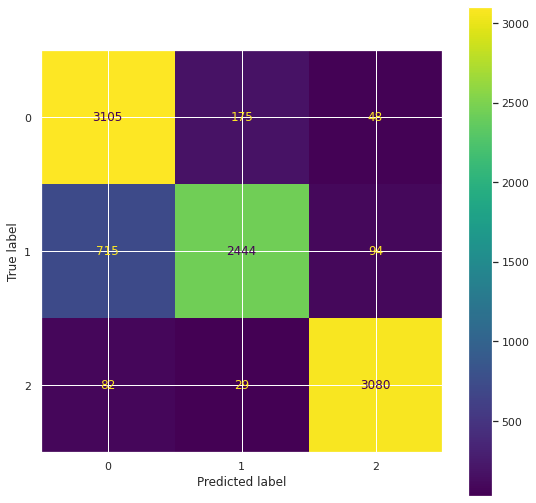

In [43]:

fig, ax = plt.subplots(figsize=(9, 9))
plot_confusion_matrix(model, test_x, test_y, ax=ax);


Основные ошибки модель допускает в двух случаях:  
- Принимает единицы за нули  
- Принимает нули за единицы  
Возможно классы сильно похожи.  
Еще можно сократить нулевой класс при синтезировании более маленьких классов.  
Тогда в выборке отношение истинной информации о маленьких классах к синтезированной будет больше.  

### Вывод:  
При точной настройке модели мы получили `macro_f1_score:` **0.874**  
Это гораздо лучше случайной модели, и выше необходимого порога **>=0.5**  
Мы нашли самые важные парамеры модели, и её слабое место (ошибки с нулями и единицами).  

Сделаем финальное предсказание на тестовой выборке.  
Запишем его в отдельный файл.  

In [44]:

output = pd.DataFrame()
output['ID'] = test['ID']

model.fit(features_scaled, target)

output['TARGET'] = model.predict(X_test)
output.to_csv('contest_answer.csv',
              index=False,
              header=output.columns
             )
